# Comparison of the dipole matrix elements with pairinteraction(v0.9) and ARC(v3.8.1)

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from ryd_numerov.rydberg_state import RydbergStateAlkali
from ryd_numerov.units import ureg

In [2]:
# A few exemplary test cases, where pairinteraction(v0.9) and ARC do fail in various ways
n_list = list(range(20, 150))

choose = "circular"

dn, dl, dj, dm = [
    (3, 1, 0, 0),
    (1, 0, 0, 0),
    (2, 0, 0, 0),
    (2, 2, 2, 0),
    (5, 1, 0, 0),
    (5, 2, 1, 0),
][0]

##### Circular states
if choose == "circular":
    qn1_list = [(n1, n1 - 1, n1 - 0.5, n1 - 0.5) for n1 in n_list]
    qn2_list = [(n + dn, l + dl, j + dj, m + dm) for n, l, j, m in qn1_list]

###### Other states
if choose == "close_to_circular":
    dl1 = 5
    qn1_list = [(n1, n1 - dl1, n1 - dl1 + 0.5, n1 - dl1 + 0.5) for n1 in n_list]
    qn2_list = [(n + dn, l + dl, j + dj, m + dm) for n, l, j, m in qn1_list]

if choose == "works_fine":
    n_list = list(range(30, 100))
    l1 = 25
    qn1_list = [(n, l1, l1 + 0.5, l1 + 0.5) for n in n_list]
    qn2_list = [(n + dn, l + dl, j + dj, m + dm) for n, l, j, m in qn1_list]

if choose == "sign_error":
    n_list = list(range(7, 80))
    qn1_list = [(n, 0, 0.5, 0.5) for n in n_list]
    qn2_list = [(n + 2, 1, 1.5, 0.5) for n in n_list]

In [3]:
results = {}

In [ ]:
matrixelements = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    q = round(qn2[-1] - qn1[-1])
    state_i = RydbergStateAlkali("Rb", n=qn1[0], l=qn1[1], j=qn1[2], m=qn1[3])
    state_f = RydbergStateAlkali("Rb", n=qn2[0], l=qn2[1], j=qn2[2], m=qn2[3])
    dipole_me = state_i.calc_matrix_element(state_f, "electric_dipole", q, unit="a.u.")
    matrixelements.append(dipole_me)

results["ryd-numerov"] = np.array(matrixelements)

In [5]:
from pairinteraction import pireal as pi

Path("./.pairinteraction_cache").mkdir(exist_ok=True)
cache = pi.MatrixElementCache("./.pairinteraction_cache/")
pi_unit_to_au = (ureg.Quantity(1, "cm/V") * ureg.Quantity(1, "GHz").to("J", "spectroscopy")).to("e * a_0").magnitude

for method in ["Numerov", "Whittaker"]:
    key = f"Pairinteraction v0.9, {method}"
    cache.setMethod(pi.NUMEROV if method == "Numerov" else pi.WHITTAKER)
    matrixelements = []
    for qn1, qn2 in zip(qn1_list, qn2_list):
        print(f"n={qn1[0]}", end="\r")
        state_i = pi.StateOne("Rb", int(qn1[0]), int(qn1[1]), qn1[2], qn1[3])
        state_f = pi.StateOne("Rb", int(qn2[0]), int(qn2[1]), qn2[2], qn2[3])

        dipole_me = cache.getElectricMultipole(state_i, state_f, 1, 1)
        matrixelements.append(dipole_me)

    results[key] = np.array(matrixelements) * pi_unit_to_au

In [6]:
import arc

atom = arc.Rubidium87()

matrixelements = []
for qn1, qn2 in zip(qn1_list, qn2_list):
    print(f"n={qn1[0]}", end="\r")
    q = int(qn2[-1] - qn1[-1])
    v = atom.getDipoleMatrixElement(
        int(qn1[0]),
        int(qn1[1]),
        float(qn1[2]),
        float(qn1[3]),
        int(qn2[0]),
        int(qn2[1]),
        float(qn2[2]),
        float(qn2[3]),
        q=int(q),
    )
    matrixelements.append(v)

results[f"ARC v{arc.__version__}"] = np.array(matrixelements)

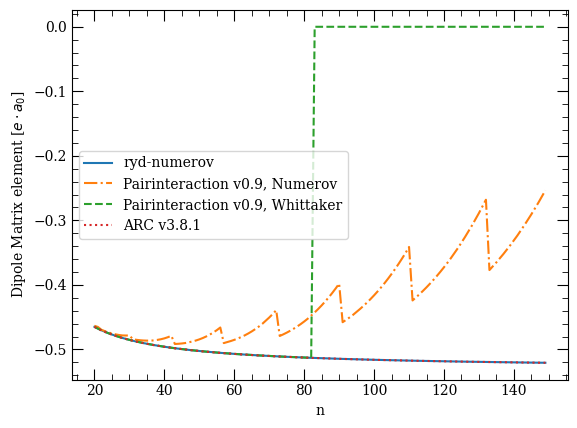

In [7]:
fig, ax = plt.subplots()

ls_dict = {"Pairinteraction v0.9, Numerov": "-.", "ARC v3.8.1": ":", "Pairinteraction v0.9, Whittaker": "--"}
for key, values in results.items():
    ls = ls_dict.get(key, "-")
    ax.plot(n_list, values, ls=ls, label=key)

ax.set_xlabel("n")
ax.set_ylabel(r"Dipole Matrix element [$e \cdot a_0$]")

ax.legend()
plt.show()